# Clustering Algorithm Test

In [124]:
%matplotlib inline
import wntr
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt 
from tqdm import *

from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import davies_bouldin_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import pairwise_distances

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import os
import sys
sys.path.append(".../master_thesis_code/")

from WaterNetWorkBasics import WaterNetWorkBasics as wnb

# Get C-Town Information

We load the .inp file within the user defined class testWN and populate:

WaterNetWorkBasics.wn = wntr.network.WaterNetworkModel(self.__filePath)

The class adds some convenience methods or properties that act directly on the network, such as:

ctown.name_list = {"node_name_list":[...], "link_name_list":[...], "control_name_list": [...], "pattern_name_list": [...] }

These names are used throughout this script.

In [90]:
ctown = wnb("c-town_true_network.inp", "c_town")

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/wntr/epanet/io.py:2085: UserWarning:

Not all curves were used in "c-town_true_network.inp"; added with type None, units conversion left to user



In [91]:
# junction name
junction_names = np.array(ctown.name_list["node_name_list"]["junction_names"])

The pipe object in wntr simulator has the following data type:
<Pipe 'P1' from 'J175' to 'J174', length=52.9, diameter=0.203, roughness=72.4549266, minor_loss=0.0, check_valve=False, status=Open>,

In [92]:
# pipe name
pipe_names = ctown.name_list["link_name_list"]["pipe_names"]

# pipe object in wntr
pipes = ctown.get_link(pipe_names)

In [93]:
# get the start and end node of pipe object in c town
pipe_start_nodes = [pipe.start_node_name for pipe in pipes]
pipe_end_nodes = [pipe.end_node_name for pipe in pipes]

## Data Preprocessing

### Pressure data

In [94]:
X = pd.read_csv("Clustering_Algorithm/pressure_0_epanet_whole.csv")
temp_list = list(X.keys())
time_list = X.values[:,0]
junction_name_list = [j for j in temp_list if j.startswith("J")]

X_pressure = X[junction_name_list].values

In [95]:
X_pressure

array([[29.966, 65.432, 34.591, ..., 20.774, 68.696, 68.696],
       [30.379, 65.563, 34.829, ..., 21.129, 69.879, 69.879],
       [30.982, 65.574, 34.978, ..., 21.532, 74.745, 74.745],
       ...,
       [30.127, 61.175, 33.714, ..., 16.719, 65.738, 65.738],
       [29.812, 63.58 , 34.829, ..., 18.444, 66.245, 66.245],
       [29.778, 63.987, 35.004, ..., 19.257, 68.091, 68.091]])

In [96]:
X_pressure.shape

(169, 388)

In [97]:
time_list

array([     0.,   3600.,   7200.,  10800.,  14400.,  18000.,  21600.,  25200.,  28800.,  32400.,  36000.,  39600.,  43200.,  46800.,  50400.,  54000.,  57600.,  61200.,  64800.,  68400.,  72000.,  75600.,  79200.,  82800.,  86400.,  90000.,  93600.,  97200., 100800., 104400., 108000., 111600.,
       115200., 118800., 122400., 126000., 129600., 133200., 136800., 140400., 144000., 147600., 151200., 154800., 158400., 162000., 165600., 169200., 172800., 176400., 180000., 183600., 187200., 190800., 194400., 198000., 201600., 205200., 208800., 212400., 216000., 219600., 223200., 226800.,
       230400., 234000., 237600., 241200., 244800., 248400., 252000., 255600., 259200., 262800., 266400., 270000., 273600., 277200., 280800., 284400., 288000., 291600., 295200., 298800., 302400., 306000., 309600., 313200., 316800., 320400., 324000., 327600., 331200., 334800., 338400., 342000.,
       345600., 349200., 352800., 356400., 360000., 363600., 367200., 370800., 374400., 378000., 381600., 385200., 

### Get Data Normalized and Visualization

In [98]:
def data_normalization(data):
    scaling_factor = np.mean(data, axis = 0).reshape(-1,1)
    normalized_data = np.zeros(data.shape)
    for i in range(data.shape[1]):
        normalized_data[:,i] = data[:,i]/scaling_factor[i]
    return normalized_data

X_pressure_normalized = data_normalization(X_pressure)

In [99]:
X_pressure_normalized

array([[0.967, 0.989, 0.902, ..., 0.851, 1.01 , 1.01 ],
       [0.98 , 0.991, 0.908, ..., 0.866, 1.028, 1.028],
       [1.   , 0.991, 0.912, ..., 0.883, 1.099, 1.099],
       ...,
       [0.972, 0.925, 0.879, ..., 0.685, 0.967, 0.967],
       [0.962, 0.961, 0.908, ..., 0.756, 0.974, 0.974],
       [0.961, 0.967, 0.913, ..., 0.789, 1.002, 1.002]])

In [100]:
X_pressure

array([[29.966, 65.432, 34.591, ..., 20.774, 68.696, 68.696],
       [30.379, 65.563, 34.829, ..., 21.129, 69.879, 69.879],
       [30.982, 65.574, 34.978, ..., 21.532, 74.745, 74.745],
       ...,
       [30.127, 61.175, 33.714, ..., 16.719, 65.738, 65.738],
       [29.812, 63.58 , 34.829, ..., 18.444, 66.245, 66.245],
       [29.778, 63.987, 35.004, ..., 19.257, 68.091, 68.091]])

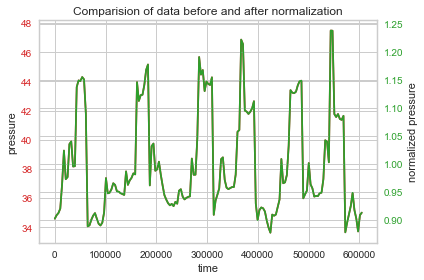

In [101]:
fig, ax1 = plt.subplots()

color = "tab:red"
plt.title("Comparision of data before and after normalization")
ax1.plot(time_list, X_pressure[:,2],color = color, label = "original data")
ax1.set_xlabel("time")
ax1.set_ylabel("pressure")
ax1.tick_params(axis="y", labelcolor = color)

ax2 = ax1.twinx()

color = "tab:green"
ax2.set_ylabel("normalized pressure")
ax2.plot(time_list, X_pressure_normalized[:,2],color=color, label = "normalized data")
ax2.tick_params(axis="y", labelcolor = color)

fig.tight_layout()
plt.show()

### Scaling Data

In [102]:
mms = MinMaxScaler()
ss = StandardScaler()
X_pressure_mms = mms.fit_transform(X_pressure)
X_pressure_ss = ss.fit_transform(X_pressure)

In [103]:
X_pressure_mms

array([[0.261, 0.363, 0.069, ..., 0.22 , 0.632, 0.632],
       [0.404, 0.374, 0.087, ..., 0.239, 0.686, 0.686],
       [0.613, 0.375, 0.097, ..., 0.261, 0.906, 0.906],
       ...,
       [0.317, 0.   , 0.006, ..., 0.   , 0.498, 0.498],
       [0.208, 0.205, 0.087, ..., 0.094, 0.521, 0.521],
       [0.196, 0.24 , 0.099, ..., 0.138, 0.605, 0.605]])

In [104]:
X_pressure_ss

array([[-1.694, -0.314, -1.071, ..., -0.824,  0.142,  0.142],
       [-1.009, -0.258, -1.003, ..., -0.744,  0.377,  0.377],
       [-0.008, -0.253, -0.961, ..., -0.652,  1.344,  1.344],
       ...,
       [-1.427, -2.128, -1.322, ..., -1.747, -0.446, -0.446],
       [-1.949, -1.103, -1.003, ..., -1.354, -0.345, -0.345],
       [-2.005, -0.93 , -0.953, ..., -1.169,  0.022,  0.022]])

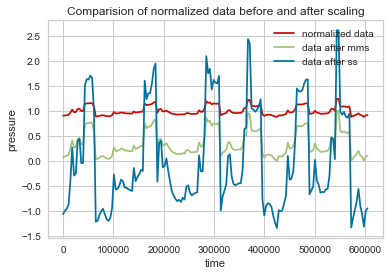

In [105]:
plt.figure()
plt.title("Comparision of normalized data before and after scaling")
plt.plot(time_list, X_pressure_normalized[:,2],"r-", label = "normalized data")
plt.plot(time_list, X_pressure_mms[:,2],"g-", label = "data after mms")
plt.plot(time_list, X_pressure_ss[:,2],"b-", label = "data after ss")
plt.xlabel("time")
plt.ylabel("pressure")
plt.legend(loc = "best")
plt.grid(True)
fig.tight_layout()
plt.show()

### PCA

In [106]:
pca = PCA().fit(X_pressure_ss)
variance = pca.explained_variance_ratio_
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

Plot the explained variance

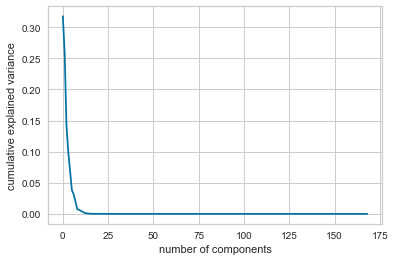

In [107]:
plt.figure()
plt.plot(variance)
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

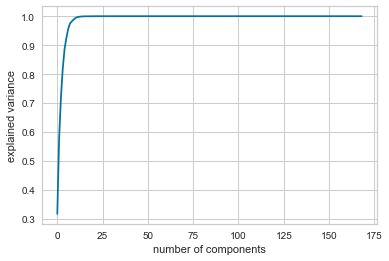

In [108]:
plt.figure()
plt.plot(cumsum_variance)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

Find the optimal n_components.

In [109]:
pca = PCA(0.99).fit(X_pressure_ss)
n_components = pca.n_components_
n_components

11

Use n_components = 11 to get the reduce X_pressure data

In [110]:
X_pressure_ss_reduced = pca.transform(X_pressure_ss)

In [111]:
X_pressure_ss_reduced.shape 

(169, 11)

So we take a data set with shape (169, 11) to represent the original data set with size of (169, 388) and then we use it in neural network.

## Feature Weight Learning

Define some helper functions

In [115]:
# using feature weight learning method to get the information about the importance of different junctions in data set

def weighted_euclidean(X, V, weights):
    dists = X - V
    return np.sqrt(np.sum((dists * weights) ** 2))


def single_delta(X, V, F):
    d = X[F] - V[F]
    return d


def cal_beta(X, d):
    n = X.shape[0]
    for b in np.linspace(0, 1.2, 1000):
        p = 1 / (1 + b * d)
        p = np.triu(p, 1)
        para = (2 / (n * (n - 1))) * np.sum(p)
        if para < 0.5:
            print(f"beta = {b}")
            return b


def return_weights(X, beta, d):
    np.seterr(divide="ignore", invalid="ignore")
    max_iter = 100
    threshold = 1e-5
    w = np.empty((1, X.shape[1]))  # initialize w matrix with the same shape as features in X data set and elements 1
    w.fill(1)
    rho_1 = 1 / (1 + beta * d)
    n = X.shape[0]
    E_old = 1
    for i in tqdm(range(0, max_iter)):
        d = pairwise_distances(X, X, metric=weighted_euclidean, **{'weights': w})
        grad_w = np.empty((1, X.shape[1]))
        part_rho_d = -beta / ((1 + beta * d) ** 2)
        rho_w = 1 / (1 + beta * d)
        E = (2 / (n * (n - 1))) * np.sum(np.triu(.5 * (rho_w * (1 - rho_1) + rho_1 * (1 - rho_w)), 1))
        print("\n")
        print(f"E = {E}")
        if E_old - E < threshold:
            print(f"{i} iterations required.\n")
            break
        E_old = E
        part_E_rho = (1 - 2 * rho_1)
        w_valid = np.where(w > 0)[1]
        #print(f'w_valid = {w_valid} \n')
        # calculate the gradient of w
        for j in w_valid:
            d_w = pairwise_distances(X, X, metric=single_delta, **{'F': j})
            #print(f'dw = {d_w}')
            part_w = np.divide(w[0, j] * (d_w ** 2), d)
            #print(f"part_w.shape = {part_w.shape}")
            #part_w = np.triu(part_w, 1)
            #print(f"part_w = {part_w}")
            part_w = np.triu(part_w, 1)
            grad_w_j = 1 / (n * (n - 1)) * part_E_rho * part_rho_d * part_w
            grad_w_j = np.triu(grad_w_j, 1)
            #grad_w_j = np.triu(grad_w_j, 1)
            grad_w[0, j] = np.nansum(grad_w_j)
            #print(f"grad_w =  {grad_w}")

        grad_w = grad_w * 2e4
        w = w - grad_w
        #print(f"w = {w}")
        w = w.clip(min=0)

    w_max = np.max(w)
    w = w / w_max # normalize w, because the minimum of w is zero, so w/(w_max - w_min) = w/(w_max - 0)
    print(f"w = {w}")
    return w

test the method by running the following code

In [116]:
X = X_pressure_normalized
print(f"X.shape = {X.shape}")

X.shape = (169, 388)


In [118]:
n = X.shape[0]
d = pairwise_distances(X, X, metric="euclidean")  # normal d
print(f"pairwise distance ={d} ")

pairwise distance =[[0.    0.504 0.992 ... 1.872 0.854 0.483]
 [0.504 0.    0.609 ... 2.145 1.232 0.706]
 [0.992 0.609 0.    ... 2.434 1.647 1.139]
 ...
 [1.872 2.145 2.434 ... 0.    1.27  1.669]
 [0.854 1.232 1.647 ... 1.27  0.    0.666]
 [0.483 0.706 1.139 ... 1.669 0.666 0.   ]] 


In [120]:
# calculate best beta
beta = cal_beta(X, d)

beta = 0.5633633633633633


In [125]:
# calculate feature weights
feature_weights = return_weights(X, beta, d)
print(f"feature weights = {feature_weights}")

  0%|          | 0/100 [00:00<?, ?it/s]



E = 0.24124702645928964


  1%|          | 1/100 [00:07<11:57,  7.25s/it]



E = 0.23926536823734854


  2%|▏         | 2/100 [00:14<11:49,  7.24s/it]



E = 0.23843530550072928


  3%|▎         | 3/100 [00:21<11:37,  7.19s/it]



E = 0.23781736937200143


  4%|▍         | 4/100 [00:29<11:38,  7.28s/it]



E = 0.23745434226434042


  5%|▌         | 5/100 [00:35<11:13,  7.09s/it]



E = 0.23715797343372708


  6%|▌         | 6/100 [00:42<10:55,  6.97s/it]



E = 0.23687865528925794


  7%|▋         | 7/100 [00:49<10:52,  7.01s/it]



E = 0.23660219811389313


  8%|▊         | 8/100 [00:56<10:38,  6.94s/it]



E = 0.23631609516076701


  9%|▉         | 9/100 [01:03<10:27,  6.89s/it]



E = 0.23600590514823858


 10%|█         | 10/100 [01:10<10:23,  6.93s/it]



E = 0.23565738627383914


 11%|█         | 11/100 [01:16<10:08,  6.84s/it]



E = 0.23526856281086855


 12%|█▏        | 12/100 [01:23<09:54,  6.75s/it]



E = 0.23488785313146138


 13%|█▎        | 13/100 [01:29<09:46,  6.74s/it]



E = 0.2346198449750465


 14%|█▍        | 14/100 [01:36<09:30,  6.63s/it]



E = 0.23444782218395388


 15%|█▌        | 15/100 [01:42<09:18,  6.57s/it]



E = 0.23431472114261212


 16%|█▌        | 16/100 [01:48<09:00,  6.44s/it]



E = 0.23420980047420922


 17%|█▋        | 17/100 [01:54<08:44,  6.32s/it]



E = 0.23412718016881046


 18%|█▊        | 18/100 [02:00<08:30,  6.22s/it]



E = 0.23406207467504758


 19%|█▉        | 19/100 [02:07<08:28,  6.27s/it]



E = 0.23401149362574


 20%|██        | 20/100 [02:14<08:43,  6.54s/it]



E = 0.23397523580452786


 21%|██        | 21/100 [02:20<08:20,  6.34s/it]



E = 0.23395291967115683


 22%|██▏       | 22/100 [02:26<07:59,  6.15s/it]



E = 0.23393769002187753


 23%|██▎       | 23/100 [02:31<07:37,  5.94s/it]



E = 0.2339257565882319


 24%|██▍       | 24/100 [02:36<07:20,  5.79s/it]



E = 0.2339162122201497
24 iterations required.

w = [[2.051e-05 7.674e-05 0.000e+00 4.943e-01 4.402e-02 0.000e+00 0.000e+00 0.000e+00 5.294e-06 6.468e-07 1.387e-08 3.641e-08 3.764e-04 3.261e-04 6.491e-04 9.369e-06 4.375e-04 1.261e-03 6.665e-04 1.139e-03 9.320e-04 8.393e-04 1.150e-03 4.090e-03 1.345e-08 0.000e+00 0.000e+00 0.000e+00 7.715e-05
  4.210e-04 3.659e-04 3.254e-02 2.450e-02 7.568e-05 3.557e-02 5.245e-06 0.000e+00 0.000e+00 1.074e-05 1.906e-05 5.441e-06 3.657e-05 5.741e-04 1.991e-06 9.673e-08 4.837e-06 0.000e+00 1.472e-07 0.000e+00 6.554e-04 1.002e-03 2.115e-10 0.000e+00 2.495e-12 6.435e-08 6.990e-11 8.070e-05 4.605e-06
  5.166e-05 1.304e-03 5.727e-06 1.764e-03 5.702e-12 2.109e-12 4.572e-07 2.206e-08 0.000e+00 9.340e-07 2.962e-05 0.000e+00 3.136e-05 0.000e+00 0.000e+00 1.152e-06 8.196e-07 0.000e+00 1.023e-04 2.467e-05 1.220e-04 1.485e-04 3.245e-05 0.000e+00 0.000e+00 7.962e-03 1.327e-02 2.847e-04 2.096e-07
  5.443e-02 4.702e-12 8.280e-04 1.485e-03 2.596e-03 4.643e-03 1.002e-0

In [134]:
feature_weights

array([[2.051e-05, 7.674e-05, 0.000e+00, 4.943e-01, 4.402e-02, 0.000e+00, 0.000e+00, 0.000e+00, 5.294e-06, 6.468e-07, 1.387e-08, 3.641e-08, 3.764e-04, 3.261e-04, 6.491e-04, 9.369e-06, 4.375e-04, 1.261e-03, 6.665e-04, 1.139e-03, 9.320e-04, 8.393e-04, 1.150e-03, 4.090e-03, 1.345e-08, 0.000e+00,
        0.000e+00, 0.000e+00, 7.715e-05, 4.210e-04, 3.659e-04, 3.254e-02, 2.450e-02, 7.568e-05, 3.557e-02, 5.245e-06, 0.000e+00, 0.000e+00, 1.074e-05, 1.906e-05, 5.441e-06, 3.657e-05, 5.741e-04, 1.991e-06, 9.673e-08, 4.837e-06, 0.000e+00, 1.472e-07, 0.000e+00, 6.554e-04, 1.002e-03, 2.115e-10,
        0.000e+00, 2.495e-12, 6.435e-08, 6.990e-11, 8.070e-05, 4.605e-06, 5.166e-05, 1.304e-03, 5.727e-06, 1.764e-03, 5.702e-12, 2.109e-12, 4.572e-07, 2.206e-08, 0.000e+00, 9.340e-07, 2.962e-05, 0.000e+00, 3.136e-05, 0.000e+00, 0.000e+00, 1.152e-06, 8.196e-07, 0.000e+00, 1.023e-04, 2.467e-05,
        1.220e-04, 1.485e-04, 3.245e-05, 0.000e+00, 0.000e+00, 7.962e-03, 1.327e-02, 2.847e-04, 2.096e-07, 5.443e-02, 

# Clustering Method

## KMeans

In [40]:
# define a result dictionary
# KMeans_dict = {"n_component":[KMeans.labels_]}

KMeans_dict = dict()

# define a list to store the sum 
# of squared distances of samples to their closest cluster center.
sum_of_squared_distances = []

# define a list to store the different clusters
n_cluster_list = np.arange(2,101)

In [42]:
# models
models_kmeans = [KMeans(n_clusters=n_cluster) for n_cluster in n_cluster_list]

# result
kmeans_result_labels = [model_kmeans.fit(X_pressure_normalized.T).labels_ for model_kmeans in models_kmeans]

In [43]:
# evaluate the result
kmeans_silhouette_score = [silhouette_score(X_pressure_normalized.T, label) for label in kmeans_result_labels]
kmeans_davies_score = [davies_bouldin_score(X_pressure_normalized.T, label) for label in kmeans_result_labels]
kmeans_calinski_score = [calinski_harabasz_score(X_pressure_normalized.T, label) for label in kmeans_result_labels]

Plot the result

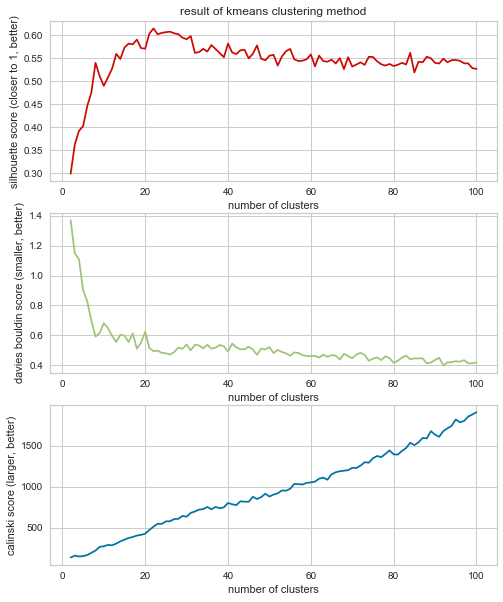

In [44]:
# plot the result
plt.figure(figsize=(8,10))

plt.subplot(311)
plt.title("result of kmeans clustering method")
plt.plot(n_cluster_list, kmeans_silhouette_score, "r-", label = "silhouette score")
plt.xlabel("number of clusters")
plt.ylabel("silhouette score (closer to 1, better)")
plt.grid(True)

plt.subplot(312)
plt.plot(n_cluster_list, kmeans_davies_score, "g-", label = "davies_bouldin_score")
plt.xlabel("number of clusters")
plt.ylabel("davies bouldin score (smaller, better)")
plt.grid(True)

plt.subplot(313)
plt.plot(n_cluster_list, kmeans_calinski_score, "b-", label = "calinski_harabasz_score")
plt.xlabel("number of clusters")
plt.ylabel("calinski score (larger, better)")
plt.grid(True)

fig.tight_layout()
plt.show()

### Visualization

KElbowVisualizer

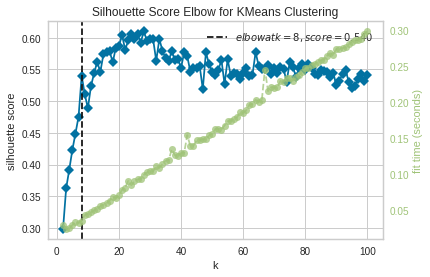

In [24]:
model = KMeans()
visualizer_silhouette = KElbowVisualizer(model, k=(2,101), metric="silhouette")
visualizer_silhouette.fit(X_pressure_normalized.T)
visualizer_silhouette.show()

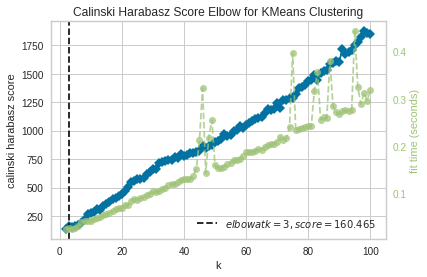

In [25]:
visualizer_calinski = KElbowVisualizer(model, k=(2,101), metric="calinski_harabasz")
visualizer_calinski.fit(X_pressure_normalized.T)
visualizer_calinski.show()

The scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center

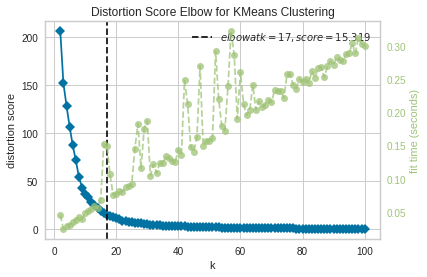

In [26]:
visualizer_distortion = KElbowVisualizer(model, k=(2,101))
visualizer_distortion.fit(X_pressure_normalized.T)
visualizer_distortion.show()

Silhouette Visualizer

In [27]:
silhouette_visualizer = [SilhouetteVisualizer(KMeans(n_clusters=n_cluster), colors='yellowbrick') for n_cluster in n_cluster_list]

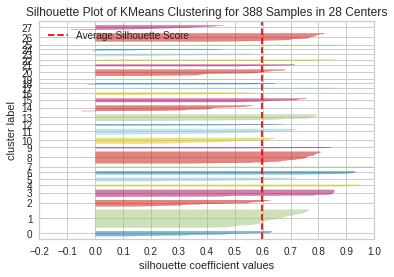

In [33]:
silhouette_visualizer_26 = silhouette_visualizer[26].fit(X_pressure_normalized.T)
silhouette_visualizer_26.show()

Plot the cluster result in c_town map

## Agglomerative

In [80]:
# define a result dictionary
# Agglomerative_dict = {"n_component":[Agglomerative.fit_predict(data)]}

Agglomerative_dict = dict()

### Connectivity Matrix

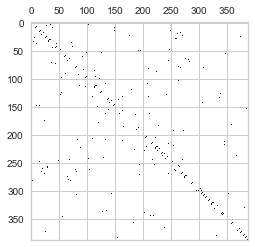

In [81]:
# build a connnectivity matrix for agglomerative training
# create a empty matrix with size of (n_junctions, n_junctions)
n_junctions = ctown.wn.num_junctions
Connect_Matrix = np.zeros((n_junctions, n_junctions))

# set the entry in A to 1 when two junctions are connected to each other in c_town map
for pipe_start_node, pipe_end_node in zip(pipe_start_nodes, pipe_end_nodes):
    i = np.where(junction_names == pipe_start_node)
    j = np.where(junction_names == pipe_end_node)
    Connect_Matrix[i, j] = 1
    Connect_Matrix[j, i] = 1

# plot the result
plt.figure()
plt.spy(Connect_Matrix)
fig.tight_layout()
plt.show()

Agglomerative Clustering without Connectivity Matrix

In [82]:
# define models
agglomerative_models = [AgglomerativeClustering(n_clusters=n_cluster, linkage="ward") 
                        for n_cluster in n_cluster_list]

# result labels
agglomerative_result_labels = [agglomerative_model.fit_predict(X_pressure_normalized.T) 
                               for agglomerative_model in agglomerative_models ]

In [83]:
# evaluate the result
agg_silhouette_score = [silhouette_score(X_pressure_normalized.T, label) for label in agglomerative_result_labels]
agg_davies_score = [davies_bouldin_score(X_pressure_normalized.T, label) for label in agglomerative_result_labels]
agg_calinski_score = [calinski_harabasz_score(X_pressure_normalized.T, label) 
                      for label in agglomerative_result_labels]

Plot the result

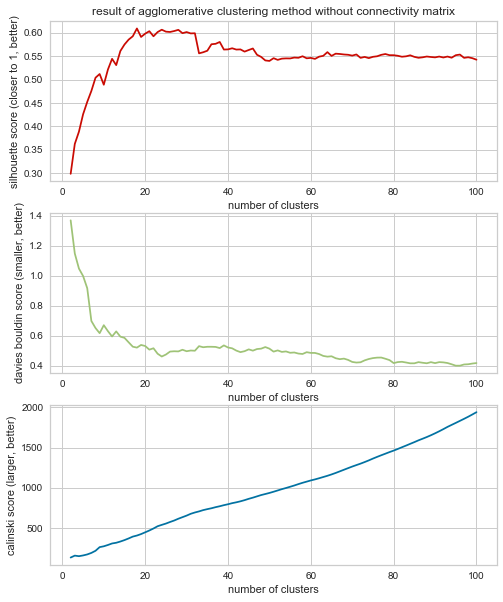

In [84]:
# plot
plt.figure(figsize=(8,10))

plt.subplot(311)
plt.title("result of agglomerative clustering method without connectivity matrix")
plt.plot(n_cluster_list, agg_silhouette_score, "r-", label = "silhouette score")
plt.xlabel("number of clusters")
plt.ylabel("silhouette score (closer to 1, better)")
plt.grid(True)

plt.subplot(312)
plt.plot(n_cluster_list, agg_davies_score, "g-", label = "davies_bouldin_score")
plt.xlabel("number of clusters")
plt.ylabel("davies bouldin score (smaller, better)")
plt.grid(True)

plt.subplot(313)
plt.plot(n_cluster_list, agg_calinski_score, "b-", label = "calinski_harabasz_score")
plt.xlabel("number of clusters")
plt.ylabel("calinski score (larger, better)")
plt.grid(True)

fig.tight_layout()
plt.show()

Agglomerative Clustering with Connectivity Matrix

In [85]:
# define models
agglomerative_models_with_connectivity_matrix = [AgglomerativeClustering(n_clusters=n_cluster, linkage="ward", connectivity=Connect_Matrix) 
                        for n_cluster in n_cluster_list]

# result labels
agglomerative_result_labels_with_connectivity_matrix = [agglomerative_model_with_connectivity_matrix.fit_predict(X_pressure_normalized.T) 
                               for agglomerative_model_with_connectivity_matrix in agglomerative_models_with_connectivity_matrix]

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/h

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/h

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.

/Users/ruizhiluo/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/h

In [86]:
# evaluate the result
agg_silhouette_score_with_connectivity_matrix = [silhouette_score(X_pressure_normalized.T, label) for label in agglomerative_result_labels_with_connectivity_matrix]

agg_davies_score_with_connectivity_matrix = [davies_bouldin_score(X_pressure_normalized.T, label) for label in agglomerative_result_labels_with_connectivity_matrix]

agg_calinski_score_with_connectivity_matrix = [calinski_harabasz_score(X_pressure_normalized.T, label) 
                      for label in agglomerative_result_labels_with_connectivity_matrix]

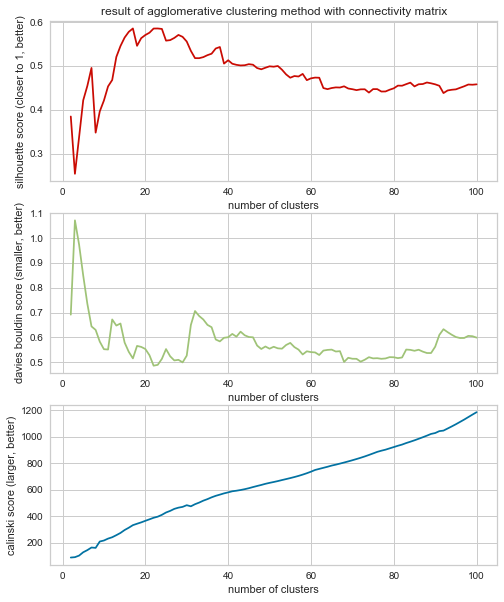

In [87]:
# plot the result
plt.figure(figsize=(8,10))

plt.subplot(311)
plt.title("result of agglomerative clustering method with connectivity matrix")
plt.plot(n_cluster_list, agg_silhouette_score_with_connectivity_matrix, "r-", label = "silhouette score")
plt.xlabel("number of clusters")
plt.ylabel("silhouette score (closer to 1, better)")
plt.grid(True)

plt.subplot(312)
plt.plot(n_cluster_list, agg_davies_score_with_connectivity_matrix, "g-", label = "davies_bouldin_score")
plt.xlabel("number of clusters")
plt.ylabel("davies bouldin score (smaller, better)")
plt.grid(True)

plt.subplot(313)
plt.plot(n_cluster_list, agg_calinski_score_with_connectivity_matrix, "b-", label = "calinski_harabasz_score")
plt.xlabel("number of clusters")
plt.ylabel("calinski score (larger, better)")
plt.grid(True)

fig.tight_layout()
plt.show()

### Visualization

## DBSCAN

### Visualization

## Spectral Clustering

### Visualization

## Gaussian Mixture Model

### Visualization

# Comparision of Result among different Methods